In [1]:
using Plots
using UnitDiskMapping, Graphs, GenericTensorNetworks, LinearAlgebra
using UnitDiskMapping.LuxorGraphPlot.Luxor, LuxorGraphPlot; LuxorGraphPlot.DEFAULT_UNIT[] = 25; 
LuxorGraphPlot.DEFAULT_BACKGROUND_COLOR[]="white";

using Distributed
if nprocs()==1
    addprocs(length(Sys.cpu_info()); exeflags=`--project=$(Base.active_project())`)
end    
println("Number of processes = $(nprocs())")

Number of processes = 97


In [2]:
@everywhere begin
    function periodic_graphene(num_x, num_y; a=1, if_draw=false, if_periodic=false)
        v1 = [3/2, √3/2] * a
        v2 = [3/2, -√3/2] * a
    
        coords = []
        for x in 0 : num_x-1
            for y in 0 : num_y-1
                push!(coords, x * v1 + y * v2 + [-a/2, 0])
                push!(coords, x * v1 + y * v2 + [a/2, 0])
            end
        end
        
        adjancency = [[1, 2] .+ y .+ 2*num_y * x for y in 0:2*(num_y-1) for x in 0 : num_x-1]
        adjancency = vcat(
            adjancency,
            [[2y, 2y+2num_y-1] .+ 2*num_y*x for y in 1:num_y for x in 0 : num_x-2]
        )
        
        periodic_adjancency = []
        if if_periodic
            periodic_adjancency = [[1, 2*((num_x-1)*num_y+1)] .+ 2y for y in 0:num_y-1]
            periodic_adjancency = vcat(
                periodic_adjancency,
                [[1, 2*num_y] .+ 2*num_y * x for x in 0 : num_x-1]
            )        
        end
    
        if if_draw
            plot([c[1] for c in coords], [c[2] for c in coords], seriestype=:scatter, aspect_ratio = :equal)
     
            for (ind1, ind2) in adjancency
                plot!([coords[ind1][1], coords[ind2][1]], [coords[ind1][2], coords[ind2][2]], color=:red, linewidth=3)
            end
            for (ind1, ind2) in periodic_adjancency
                plot!([coords[ind1][1], coords[ind2][1]], [coords[ind1][2], coords[ind2][2]], color=:blue, linewidth=3)
            end        
            for (ind, (x, y)) in enumerate(coords)
                annotate!(x, y, Plots.text("$ind", :top, 10))
            end        
            plot!(title="(num_y) graphe", legend=:false)            
            display(current())
        end
            
        adjancency = vcat(adjancency, periodic_adjancency)            
            
        return coords, adjancency
        
    end
             
    function periodic_graphene_2(num_x, num_y; a=1, if_draw=false, if_periodic=false)
        if mod(num_x, 2) != 0
            error("num_x should be an even number")
        end
        
    
        pair_1 = [[0, 0], [-1/2, √3/2]*a]
        chain_1 = []
        for y in 0 : num_y-1
            chain_1 = vcat(chain_1, pair_1 .+ [[0, √3 * a] .* y])
        end
        pair_2 = [[a, 0], [3/2, √3/2]*a]
        chain_2 = []
        for y in 0 : num_y-1
            chain_2 = vcat(chain_2, pair_2 .+ [[0, √3 * a] .* y])
        end    
        
        coords = []
        for x in 1 : num_x
            mod(x, 2) == 1 && (
                coords = vcat(coords, chain_1 .+ [[3a, 0] .* floor((x-1)/2)])
            )
            mod(x, 2) == 0 && (
                coords = vcat(coords, chain_2 .+ [[3a, 0] .* floor((x-1)/2)])
            )        
        end
    
        adjacency = [[1, 2] .+ y .+ 2*num_y * x for y in 0:2*(num_y-1) for x in 0 : num_x-1]
        adjacency = vcat(
            adjacency,
            [[2y-1, 2y+2num_y-1] .+ 2*num_y*x for y in 1:num_y for x in 0 : 2 : num_x-2],
            [[2y, 2y+2num_y] .+ 2*num_y*x for y in 1:num_y for x in 1 : 2 : num_x-2]
        )
    
        periodic_adjacency = []
        if if_periodic
            periodic_adjacency = [[2, 2*(num_x-1)*num_y+2] .+ 2y for y in 0:num_y-1]
            periodic_adjacency = vcat(
                periodic_adjacency,
                [[1, 2*num_y] .+ 2*num_y * x for x in 0 : num_x-1]
            )        
        end
        
        if if_draw
            plot([c[1] for c in coords], [c[2] for c in coords], seriestype=:scatter, aspect_ratio = :equal)
     
            for (ind1, ind2) in adjacency
                plot!([coords[ind1][1], coords[ind2][1]], [coords[ind1][2], coords[ind2][2]], color=:red, linewidth=3)
            end
            for (ind1, ind2) in periodic_adjacency
                plot!([coords[ind1][1], coords[ind2][1]], [coords[ind1][2], coords[ind2][2]], color=:blue, linewidth=1)
            end        
            for (ind, (x, y)) in enumerate(coords)
                annotate!(x, y, Plots.text("$ind", :top, 10))
            end        
            plot!(title="$(num_x)x$(num_y) graphene", legend=:false)            
            display(current())
        end    
    
        adjacency = vcat(adjacency, periodic_adjacency)            
        
        return coords, adjacency
    end
end

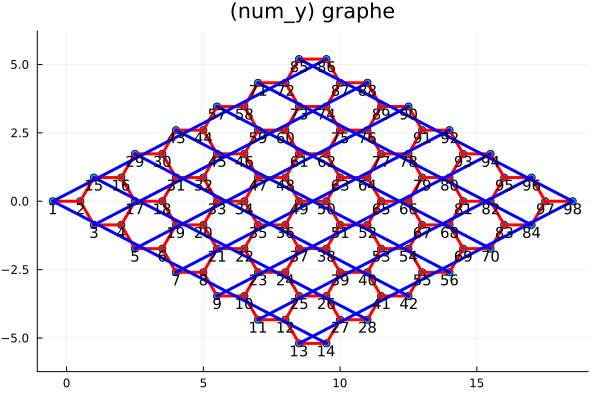

In [3]:
periodic_graphene(7, 7, if_draw=true, if_periodic=true) ;

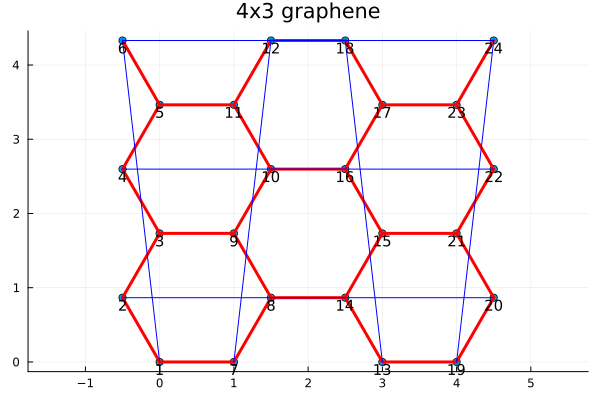

In [4]:
num_x, num_y = 4, 3
coordinates, adjacency = periodic_graphene_2(num_x, num_y, if_periodic=true, if_draw=true) ;

# We will focus on the second type of graphene structure for the rest of the notebook

# First we notice that the QUBO defined on that graphene structure can be solved exactly, regardless if the graphene has periodic or open boundary conditions. 

# Let us look at the periodic geometry first. 

In [5]:
function draw_sol(qubo_sol, coordinates, adjacency, J1val)
    
    g = plot([c[1] for c in coordinates], [c[2] for c in coordinates], seriestype=:scatter, aspect_ratio = :equal)
    
    for (ind1, ind2) in adjacency
        plot!([coordinates[ind1][1], coordinates[ind2][1]], [coordinates[ind1][2], coordinates[ind2][2]], color=:red, linewidth=3)
    end
    
    for (ind, (x, y)) in enumerate(coordinates)
        annotate!(x, y, Plots.text("$ind", :top, 10))
    end
    
    highlighted_atoms = coordinates[findall(x->x!=0, qubo_sol)]
    
    plot!([c[1] for c in highlighted_atoms], [c[2] for c in highlighted_atoms], 
        seriestype=:scatter, markershape=:star5, markersize = 10, color=:yellow)
    
    plot!(title="$(num_x)x$(num_y) graphene, $(J1val)\n num_ryd = $(length(highlighted_atoms))", legend=:false)            
    return g  
end

function draw_num_ryd_energy(J1range, J2, qubo_sols, energies, if_periodic)
    plot(J1range, [sum(item) for item in qubo_sols], marker=:circle)
    vline!([-3*J2], label="predicted transition in periodic struture")
    hline!([2*num_x*num_y, num_x*num_y], label="two phases in periodic structure")
    if if_periodic == false
        vline!([-2*J2, -J2], label="two more predicted transition in open struture")
        hline!([num_x*num_y+1+(num_x-1+num_y-1), num_x*num_y+1], label="two more phases in open structure")
    end
    g1 = plot!(xlabel="J1", ylabel="num of ryd", title="num of ryd, $(num_x) x $(num_y), J2 = $(J2)")
    
    g2 = plot()
    plot!(J1range, energies, marker=:circle)
    plot!(xlabel="J1", ylabel="energy", title="energy, $(num_x) x $(num_y), J2 = $(J2)")
    
    plot(g1, g2, size=(1000, 400))
    display(current())    
end

function solve_periodic_graphene_2(num_x, num_y, J1range, J2; if_periodic=false)
    coordinates, adjacency = periodic_graphene_2(num_x, num_y, if_periodic=if_periodic)
    
    qubo_sols = []
    energies = []
    for J1 in J1range
        
        J = zeros(length(coordinates), length(coordinates))
        for (i, j) in adjacency
            J[i, j] = J2
            J[j, i] = J2
        end
        h = ones(length(coordinates)) * J1
        
        qubo_sol = collect(Int, solve(SpinGlass(J, h), SingleConfigMax())[].c.data)
        push!(qubo_sols, qubo_sol)
    
        energy = sum(h[findall(x->x!=0, qubo_sol)])
        energy += sum(
            [(qubo_sol[i] == 1 && qubo_sol[j] == 1) ? J2 : 0
                for (i, j) in adjacency
            ]
        )
    
        push!(energies, energy)
    end

    draw_num_ryd_energy(J1range, J2, qubo_sols, energies, if_periodic)

    if if_periodic
        g1 = draw_sol(qubo_sols[1], coordinates, adjacency, J1range[1])
        g2 = draw_sol(qubo_sols[end], coordinates, adjacency, J1range[end])
        plot(g1, g2, size=(1000, 400))
        display(current()) 
    else
        g1 = draw_sol(qubo_sols[1], coordinates, adjacency, J1range[1])
        g2 = draw_sol(qubo_sols[20], coordinates, adjacency, J1range[20])
        g3 = draw_sol(qubo_sols[45], coordinates, adjacency, J1range[45])
        g4 = draw_sol(qubo_sols[end], coordinates, adjacency, J1range[end])
        plot(g1, g2, g3, g4, size=(1000, 800))
        display(current()) 
    end

    return coordinates, adjacency, qubo_sols, energies 
end

solve_periodic_graphene_2 (generic function with 1 method)

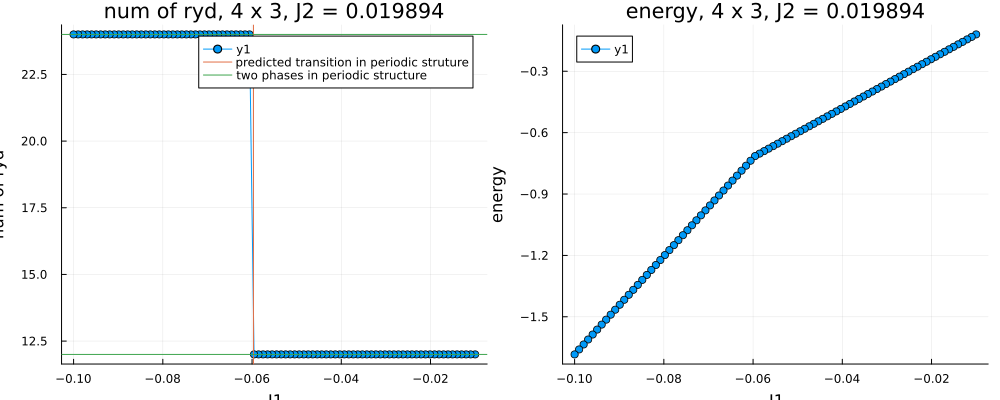

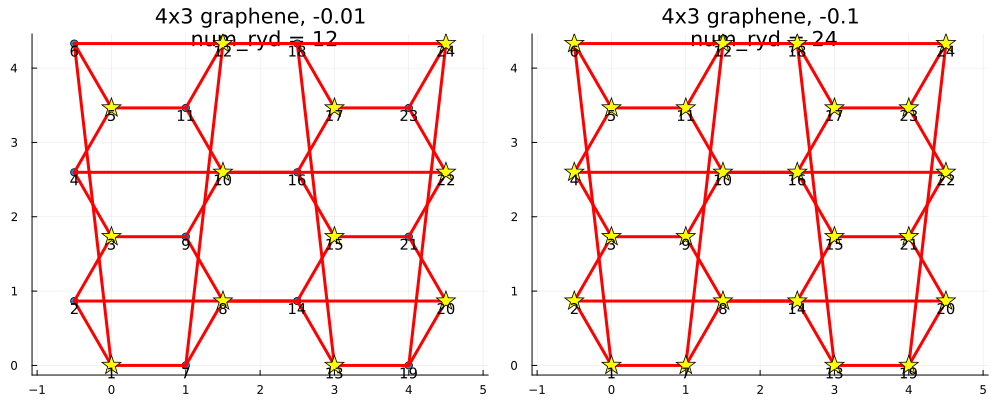

In [6]:
J2 = 0.019894
# J2 = 0.029894
# J2 = 0.009894
J1range = range(-0.01, -0.1, 90)

solve_periodic_graphene_2(num_x, num_y, J1range, J2, if_periodic=true) ;

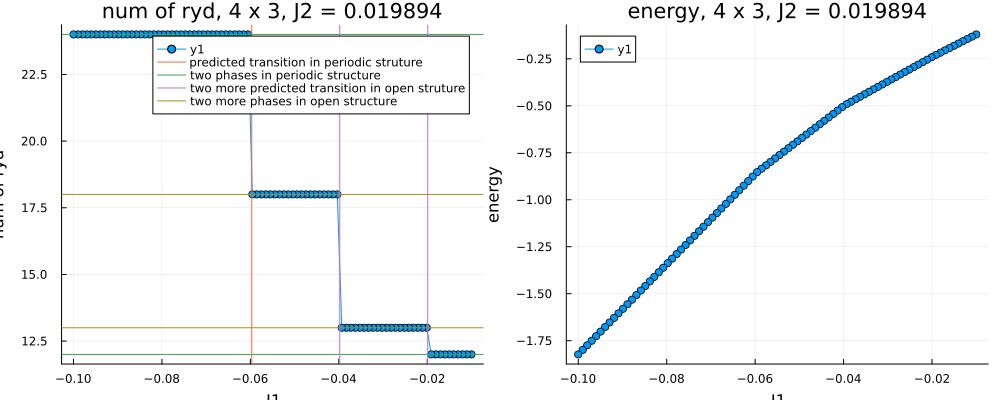

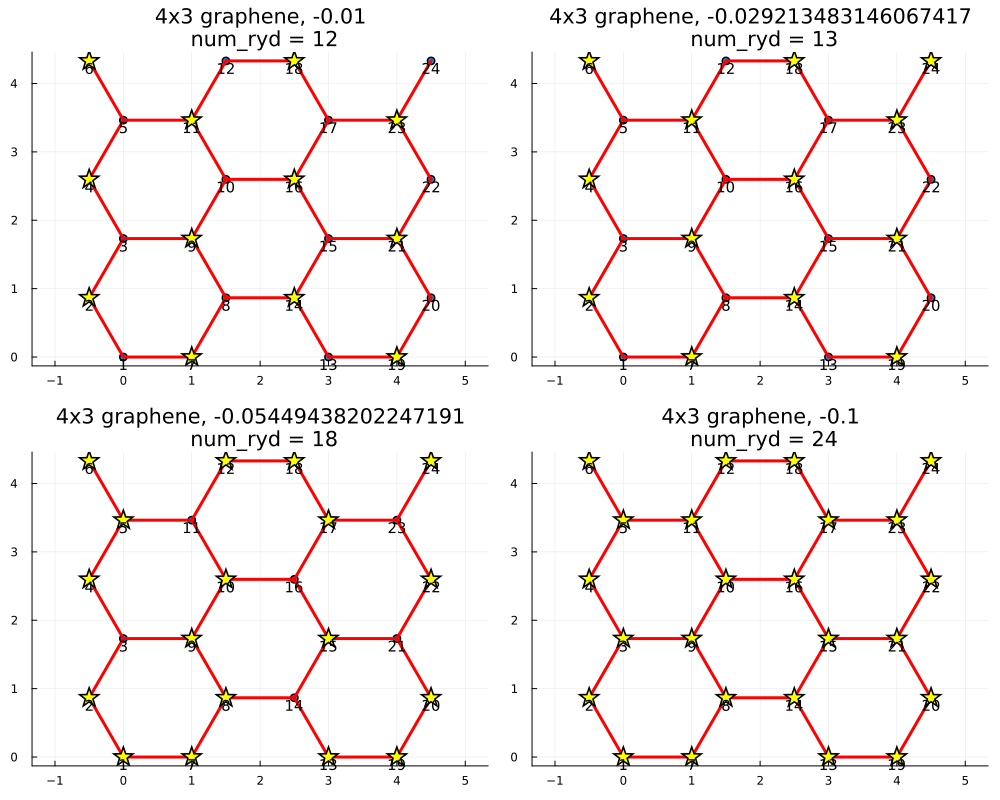

In [7]:
J2 = 0.019894
# J2 = 0.029894
# J2 = 0.009894
J1range = range(-0.01, -0.1, 90)

solve_periodic_graphene_2(num_x, num_y, J1range, J2, if_periodic=false) ;

# Next we show it is possible to find the solution for the graphene structure in periodic boundary condition, by using the same structure but in open periodic structure with local detuning applied on the boundary. 

In [8]:
@everywhere begin
    using Optim
    using UnitDiskMapping, Graphs, GenericTensorNetworks, LinearAlgebra

    function get_j_h_open(num_x, num_y, J1, J2, J3_var)
        J3, J3_2 = J3_var[1], J3_var[2]
        coordinates, open_adjacency = periodic_graphene_2(num_x, num_y, if_periodic=false)
    
        J_open = zeros(length(coordinates), length(coordinates))
        for (i, j) in open_adjacency
            J_open[i, j] = J2
            J_open[j, i] = J2
        end
        h_open = ones(length(coordinates)) * J1
        boundary_atoms = vcat(
            2:2num_y-1, 
            2*num_x*num_y - 2num_y +2 : 2*num_x*num_y-1,
            [[1,2num_y+1] .+ 4num_y * i for i in 0 : Int(num_x/2)-1]...,
            [[2num_y,4num_y] .+ 4num_y * i for i in 0 : Int(num_x/2)-1]...,
            )
        
        for i in boundary_atoms
            if i ∈ [2num_y, 2num_x * num_y]
                h_open[i] += J3_2
            else
                h_open[i] += J3
            end
        end
        return coordinates, J_open, h_open
    end
    
    function f(num_x, num_y, J1, J2, J3_var)
        coordinates, J_open, h_open = get_j_h_open(num_x, num_y, J1, J2, J3_var)
        
        qubo_sol = collect(Int, solve(SpinGlass(J_open, h_open), SingleConfigMax())[].c.data)

        # calculate the energy in the periodic structure
        _, periodic_adjacency = periodic_graphene_2(num_x, num_y, if_periodic=true)
        h_periodic = ones(length(coordinates)) * J1
                
        energy = sum(h_periodic[findall(x->x!=0, qubo_sol)])
        energy += sum(
            [(qubo_sol[i] == 1 && qubo_sol[j] == 1) ? J2 : 0
                for (i, j) in periodic_adjacency
            ]
        )
        return energy
    end
end

In [9]:
function solve_periodic_graphene_2_with_open_boundary(num_x, num_y, J1range, J2; num_trial=1000)

    function get_minimum_minimizer_list(J3s, num_x, num_y, J1, J2)
        return pmap(J3s) do J3
            solver = NelderMead()  # SimulatedAnnealing() # NelderMead() 
            res = optimize(J3_var -> f(num_x, num_y, J1, J2, J3_var), 
                J3, solver, Optim.Options(iterations=2000, show_trace=false, show_every=10))
            minimum = Optim.minimum(res)
            minimizer = Optim.minimizer(res)
    
            [minimum, minimizer]
        end;
    end
    
    qubo_sols = []
    energies = []
    minimizers = []
    for (ind_J1, J1) in enumerate(J1range)
        println("$(ind_J1)/$(length(J1range))")
        # J3s = [[rand() * 0.1] for _ in 1 : num_trial]
        J3s = [rand(2) * 0.1 for _ in 1 : num_trial]
        minimum_minimizer_list = @time get_minimum_minimizer_list(J3s, num_x, num_y, J1, J2) ;  
    
        energy = minimum([minimum_minimizer_list[i][1] for i in 1:num_trial])  
        push!(energies, energy)
        minimizer = minimum_minimizer_list[argmin([minimum_minimizer_list[i][1] for i in 1:num_trial])][2] 
        push!(minimizers, minimizer)

        _, J_open, h_open = get_j_h_open(num_x, num_y, J1, J2, minimizer)
        
        qubo_sol = collect(Int, solve(SpinGlass(J_open, h_open), SingleConfigMax())[].c.data);     
        push!(qubo_sols, qubo_sol)
    end

    return qubo_sols, energies
end

solve_periodic_graphene_2_with_open_boundary (generic function with 1 method)

In [10]:
# same parameters [num_x, num_y, J1range, J2] as defined above

qubo_sols, energies = solve_periodic_graphene_2_with_open_boundary(num_x, num_y, J1range, J2);

1/90
 32.674938 seconds (1.44 M allocations: 74.044 MiB, 2.71% compilation time)
2/90
  3.306535 seconds (58.58 k allocations: 2.407 MiB, 3.76% gc time)
3/90
  3.251753 seconds (58.65 k allocations: 2.421 MiB)
4/90
  3.499552 seconds (58.65 k allocations: 2.425 MiB)
5/90
  3.145271 seconds (58.64 k allocations: 2.430 MiB)
6/90
  3.325221 seconds (58.66 k allocations: 2.417 MiB)
7/90
  2.867897 seconds (58.64 k allocations: 2.425 MiB)
8/90
  2.936451 seconds (58.65 k allocations: 2.425 MiB)
9/90
  3.079624 seconds (58.65 k allocations: 2.425 MiB)
10/90
  2.822272 seconds (58.63 k allocations: 2.424 MiB)
11/90
  3.268274 seconds (58.63 k allocations: 2.424 MiB)
12/90
  2.988582 seconds (58.62 k allocations: 2.404 MiB)
13/90
  3.062592 seconds (58.64 k allocations: 2.424 MiB)
14/90
  2.721388 seconds (58.62 k allocations: 2.424 MiB)
15/90
  2.832717 seconds (58.64 k allocations: 2.424 MiB)
16/90
  2.724252 seconds (58.64 k allocations: 2.417 MiB)
17/90
  3.094183 seconds (58.65 k allocati

We plot the results for the open structure with local detuning below. We find that it agrees well with that obtained on the periodic structure.

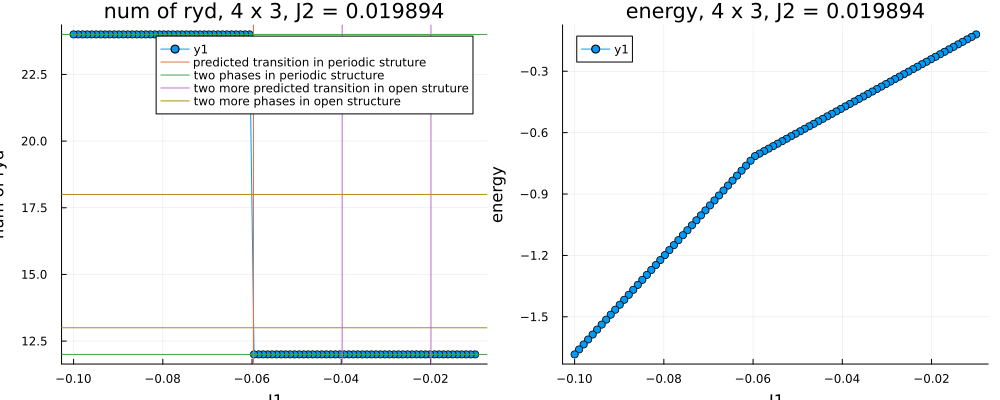

In [11]:
draw_num_ryd_energy(J1range, J2, qubo_sols, energies, false)